In [10]:
import os,pickle
import matplotlib.pylab as plt
from scipy.interpolate import UnivariateSpline as Smooth
import argparse


import numpy as np
from scipy.interpolate import interp1d
import csv

def T(ba,ca):
    return( (1-ba**2)/(1-ca**2) )
T_s,T_d = [],[]
B_s,C_s,B_d,C_d = [],[],[],[]
masses, triaxialities = [],[]
Reff = []

In [11]:
feedback = 'AK'
sim = 'storm'
SimInfo = pickle.load(open('SimulationInfo.AK.pickle','rb'))

DMShapes = pickle.load(open(f'../Data/{sim}.{feedback}.DMShapes.pickle','rb'))
csv_file_path ='Storm_SIDM_good_halos.txt'

r_f = .1



In [14]:
feedback = 'AB'
sim = 'storm'
SimInfo = pickle.load(open('SimulationInfo.AB.pickle','rb'))

DMShapes = pickle.load(open(f'../Data/{sim}.{feedback}.DMShapes.pickle','rb'))
csv_file_path ='storm_CDM_good_halos.txt'

r_f = .1



[108900. 108900. 108900. 108899. 108901. 108899. 108901. 108900. 108900.
 108900. 108900. 108900. 108899. 108901. 108900. 108899. 108901. 108900.
 108900. 108900. 108900. 108899. 108901. 108900. 108900. 108900. 108900.
 108900. 108899. 108901. 108900. 108899. 108901. 108899. 108901. 108899.
 108900. 108901. 108900. 108900. 108900. 108900. 108900. 108900. 108900.
 108900. 108899. 108901. 108900. 108900. 108900. 108899. 108901. 108900.
 108899. 108901. 108900. 108900. 108900. 108900. 108900. 108900. 108900.
 108899. 108900. 108901. 108899. 108901. 108900. 108900. 108900. 108900.
 108900. 108900. 108900. 108900. 108900. 108900. 108899. 108900. 108901.
 108900. 108900. 108900. 108900. 108900. 108900. 108899. 108901. 108900.
 108900. 108900. 108900. 108899. 108901. 108900. 108899. 108901. 108900.
      0.]


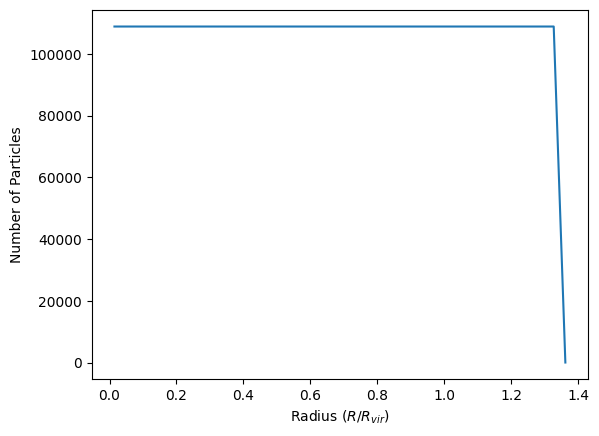

In [15]:
import traceback
shapes = []
numbers = []
with open(csv_file_path, newline='') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        if row:  # Make sure the row isn't empty
            numbers.append(int(row[0]))  # Assuming each row contains one number

# Assuming SimInfo and sim are already defined, you update goodhalos here:
SimInfo[sim]['goodhalos'] = numbers

fig, ax = plt.subplots()
for hid in SimInfo[sim]['goodhalos']:
    try:
        rd = DMShapes[str(hid)]['rbins']
        ba_d = DMShapes[str(hid)]['ba']
        ca_d = DMShapes[str(hid)]['ca']
        mass = DMShapes[str(hid)]['M']
        #Reff = DMShapes[str(hid)]['reff']
        r_vir = DMShapes[str(hid)]['r_vir']
        particle_counts = DMShapes[str(hid)]['particle_counts']
        
        if hid == 1:
            normalized_rd = rd / r_vir  # Normalize the radial distances by the virial radius

            # Creating the plot
            
            ax.plot(normalized_rd, particle_counts, linestyle='-')  # Using markers for clarity
            
            # Adding axis labels and a title
            ax.set_xlabel('Radius ($R/R_{vir}$)')
            ax.set_ylabel('Number of Particles')
            
            # Print particle counts to the console
            print(particle_counts)
            
            # Ensure the directory exists where the plot will be saved
            output_directory = "../Figures"
            if not os.path.exists(output_directory):
                os.makedirs(output_directory)
            
            # Save the plot to the desired directory
            file_path = os.path.join(output_directory, "particle_distribution_plot.png")
            plt.savefig(file_path, bbox_inches='tight')
            
            # Show the plot
            plt.show()
        
        # Close the plot to free up system resources
        #plt.close(fig)
            

        # Create smoothed functions for ba and ca using UnivariateSpline
        ba_d_smoothed = Smooth(rd, ba_d, k=3)
        ca_d_smoothed = Smooth(rd, ca_d, k=3)

        # Evaluate the smoothed functions at Reff
        ba_d_at_Reff = ba_d_smoothed(r_vir*r_f)
        ca_d_at_Reff = ca_d_smoothed(r_vir*r_f)

        # Store all necessary data for later use
        shapes.append({
            "hid": hid,
            "rd": rd,
            "ba_d": ba_d,
            "ca_d": ca_d,
            "ba_d_smoothed": ba_d_smoothed,
            "ca_d_smoothed": ca_d_smoothed,
            "ba_d_at_Reff": ba_d_at_Reff,
            "ca_d_at_Reff": ca_d_at_Reff,
            "mass": mass,
            "T_val": T(ba_d_at_Reff, ca_d_at_Reff),
            "R_vir": r_vir,
            
        })

    except Exception as e:
        print(f"An error occurred for halo {hid}: {e}")
        traceback.print_exc()
pickle.dump(shapes,open(f'../Data/{sim}.{feedback}.DarkShapes.pickle','wb'))


In [17]:
print(r_vir)


8.226962316866803


In [16]:
for Shapes in shapes:
    try:
        fig, ax = plt.subplots(figsize=(8, 2))
        Rvir = Shapes['R_vir']
        
        # Normalize radius by Rvir
        normalized_rd = Shapes['rd'] / Rvir
        
        # Filter arrays to include only radii within the virial radius
        within_virial = normalized_rd <= 1
        filtered_rd = normalized_rd[within_virial]
        filtered_ba_d = np.array(Shapes['ba_d'])[within_virial]
        filtered_ca_d = np.array(Shapes['ca_d'])[within_virial]
        
        # Use the filtered data for plotting
        ax.plot(filtered_rd, filtered_ba_d, c='k', label='b/a')
        ax.plot(filtered_rd, filtered_ca_d, c='k', linestyle='--', label='c/a')
        
        # If your smoothed functions are callable and can handle arrays, filter their inputs similarly
        if callable(Shapes['ba_d_smoothed']) and callable(Shapes['ca_d_smoothed']):
            smoothed_ba = Shapes['ba_d_smoothed'](Shapes['rd'])[within_virial]
            smoothed_ca = Shapes['ca_d_smoothed'](Shapes['rd'])[within_virial]
            ax.plot(filtered_rd, smoothed_ba, c='r', label='Smoothed b/a')
            ax.plot(filtered_rd, smoothed_ca, c='r', linestyle='--', label='Smoothed c/a')
        
        ax.set_xlabel(r'Radius ($R/R_{vir}$)')
        ax.set_ylabel('Axis Ratio')
        ax.set_title(f"Halo: {Shapes['hid']} Axis Ratios; $R_{{vir}} = {Rvir:.2f}$")


        ax.legend()
        hid = Shapes['hid']
        filepath = f'../Figures/3DShapes/{sim}.{feedback}/{hid}.Dark.png'
        directory = os.path.dirname(filepath)
        os.makedirs(directory, exist_ok=True)
        
        plt.savefig(filepath, bbox_inches='tight', pad_inches=.1)
        plt.close(fig)  # Make sure to close the plot to free up memory

    except Exception as e:
        print(f"An error occurred while processing halo {hid}: {e}")

In [18]:
#load pickle file paramaters

def load_pickle(sim,feedback):
    # Path to the pickle file for each simulation
    pickle_file_path = f'../Data/{sim}.{feedback}.DarkShapes.pickle'
    
    # Reading the pickle file
    with open(pickle_file_path, 'rb') as file:
        # Load data from the file and store it in the dictionary
        return pickle.load(file)

AK = load_pickle(sim,'AK') #SDIM
AB = load_pickle(sim,'AB') #CDM



#first column is CDM
#second is SIDM
matched_halos = []
with open('matched.txt', 'r') as file:
    for line in file:
        ids = line.split()
        matched_halos.append((int(float(ids[1])), int(float(ids[0]))))
#print(matched_halos)

# Prepare lists for plotting
mass_AK = []
mass_AB = []
T_AK = []
T_AB = []
ba_AK = []
ca_AK = []
ba_AB = []
ca_AB = []
ba_l = []
ca_l = []


# Extract masses and triaxialities for matched halos
for hid_AK, hid_AB in matched_halos:
    # Assuming 'AK' and 'AB' data is a list of dictionaries with 'hid' as one of the keys
    ak_entry = next((item for item in AK if item['hid'] == hid_AK), None)
    ab_entry = next((item for item in AB if item['hid'] == hid_AB), None)
    if ak_entry and ab_entry:
        mass_AK.append(ak_entry['mass']) 
        mass_AB.append(ab_entry['mass'])  
        T_AK.append(ak_entry['T_val'])
        T_AB.append(ab_entry['T_val'])
        ba_AK.append(ak_entry['ba_d_at_Reff'])
        ca_AK.append(ak_entry['ca_d_at_Reff'])
        ba_AB.append(ab_entry['ba_d_at_Reff'])
        ca_AB.append(ab_entry['ca_d_at_Reff'])

        
        
        
  

In [20]:

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.cm as cm

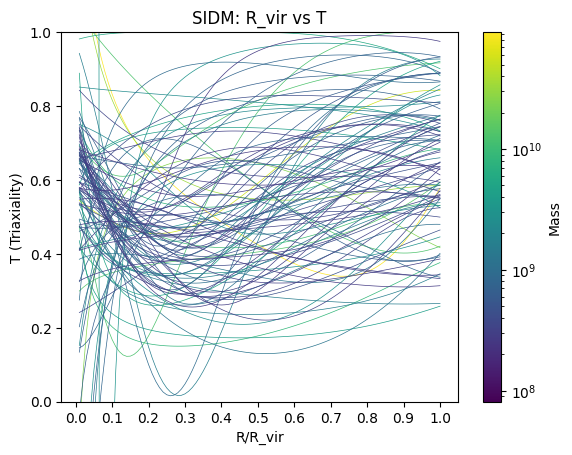

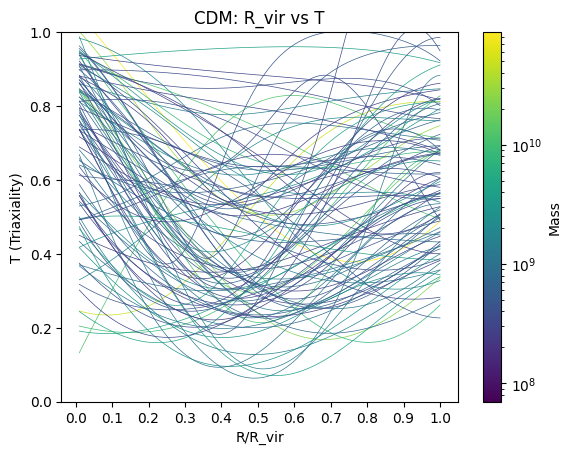

In [26]:

def plot_rrvir_vs_t(data, title):
    fig, ax = plt.subplots()
    # Prepare the colormap and the log-normal normalization
    masses = [entry['mass'] for entry in data]
    norm = mcolors.LogNorm(vmin=min(masses), vmax=max(masses))
    cmap = cm.viridis  # You can choose any other colormap e.g., cm.plasma, cm.inferno
    i = 0
    evaluation_points = np.linspace(0.01, 1, num=100)
    for entry in data:
        actual_radii = evaluation_points * entry['R_vir']
        ba_d_evaluated = [entry['ba_d_smoothed'](r) for r in actual_radii]
        ca_d_evaluated = [entry['ca_d_smoothed'](r) for r in actual_radii]
        t_vals = [T(ba, ca) for ba, ca in zip(ba_d_evaluated, ca_d_evaluated)]

        # Get the color for the current halo based on its mass
        color = cmap(norm(entry['mass']))

        ax.plot(evaluation_points, t_vals, color=color, lw=.5)  # Use color for the line
        i = i+1
        if i == 100:
            break

    # Adding a colorbar
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # You can set clim if you want different limits for your colorbar
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Mass')

    ax.set_ylim(0, 1)
    ax.set_xlabel("R/R_vir")
    ax.set_ylabel("T (Triaxiality)")
    ax.set_title(title)
    ax.set_xticks(np.linspace(0,1,11))
    plt.savefig(f'../Figures/{title.replace(" ", "_")}.png', format='png', dpi=500)  # Save as PNG with high resolution

    plt.show()

# Assuming AK and AB data are loaded and formatted correctly
# Plot for SIDM
plot_rrvir_vs_t(AK, "SIDM: R_vir vs T")

# Plot for CDM
plot_rrvir_vs_t(AB, "CDM: R_vir vs T")






In [39]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import os

# Triaxiality function
def T(ba, ca):
    return (1 - ba**2) / (1 - ca**2)

def plot_rrvir_vs_t(entry_AK, entry_AB, hid_AK, hid_AB, title, norm):
    fig, ax = plt.subplots()
    
    padded_hid_AK = str(hid_AK).zfill(3)
    padded_hid_AB = str(hid_AB).zfill(3)

    # Directory setup with padded IDs
    directory_path = f'../Figures/R_vir_vs_T/'
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

    cmap = cm.viridis  # Colormap selection
    evaluation_points = np.linspace(0.01, 1, num=100)
    linestyles = ['solid','dotted']
    
    for entry, label,linestyle in zip([entry_AK, entry_AB], ['SIDM', 'CDM'],linestyles):
        actual_radii = evaluation_points * entry['R_vir']
        ba_d_evaluated = [entry['ba_d_smoothed'](r) for r in actual_radii]
        ca_d_evaluated = [entry['ca_d_smoothed'](r) for r in actual_radii]
        t_vals = [T(ba, ca) for ba, ca in zip(ba_d_evaluated, ca_d_evaluated)]
        color = cmap(norm(entry['mass']))
        ax.plot(evaluation_points, t_vals,ls=linestyle, color=color, lw=2, label=label)

    # Colorbar and labels
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Log Mass')
    
    ax.set_ylim(0, 1)
    ax.set_xlabel("R/R_vir")
    ax.set_ylabel("T (Triaxiality)")
    ax.set_title(f"Triaxiality for Halo Pair {hid_AK} (SIDM) and {hid_AB} (CDM)")
    ax.legend()

    # Save the figure
    file_path = f'{directory_path}/{title.replace(" ", "_")}_{padded_hid_AK}_{padded_hid_AB}.png'
    plt.savefig(file_path, format='png', dpi=300)
    plt.close(fig)  # Close the figure to free up memory

# Collect all masses
all_masses = [item['mass'] for item in AK + AB]
norm = mcolors.LogNorm(vmin=min(all_masses), vmax=max(all_masses))

# Match and plot for each pair of halos
for hid_AK, hid_AB in matched_halos:
    entry_AK = next((item for item in AK if item['hid'] == hid_AK), None)
    entry_AB = next((item for item in AB if item['hid'] == hid_AB), None)
    if entry_AK and entry_AB:
        plot_rrvir_vs_t(entry_AK, entry_AB, hid_AK, hid_AB, "R_vir_vs_T", norm)


NameError: name 'padded_hid_AK' is not defined

In [ ]:



def create_and_save_plot(filename, show_scatter=True, show_lines=True):
    fig = plt.figure(figsize=(10, 8))
    gs = gridspec.GridSpec(2, 2, width_ratios=[10, 1], height_ratios=[1, 5])

    ax = plt.subplot(gs[1, 0])
    ax_histy = plt.subplot(gs[1, 1], sharey=ax)

    for m_AK, m_AB, T_ak, T_ab in zip(mass_AK, mass_AB, T_AK, T_AB):
        log_m_AK = np.log10(m_AK)
        log_m_AB = np.log10(m_AB)

        if show_scatter:
            avg = (m_AK + m_AB) / 2
            diff = (m_AK - m_AB) / avg
        
            if diff > 0.1:
                ax.scatter(np.log10(m_AK), T_ak, color='blue', s=100, marker='*', alpha=0.75, label=r'$\Delta M > 10\%$')
                ax.scatter(np.log10(m_AB), T_ab, color='red', s=100, marker='*', alpha=0.75)
            else:
                ax.scatter(log_m_AK, T_ak, color='blue', s=30, alpha=0.5, label='Storm SIDM')
                ax.scatter(log_m_AB, T_ab, color='red', s=30, alpha=0.5, label='Storm CDM')

        if show_lines:
            ax.plot([log_m_AK, log_m_AB], [T_ak, T_ab], 'k-', alpha=0.5)

    ax.set_xlabel(r'Log(M$_D$/M$_\odot$)', fontsize=25)
    ax.set_ylabel(r'T$_D$', fontsize=25)
    ax.set_title('Mass vs. Triaxiality')
    ax.set_ylim([0, 1.01])

    ax.plot([6, 12.5], [1/3, 1/3], c='.75', linestyle='--', zorder=0)
    ax.plot([6, 12.5], [2/3, 2/3], c='.75', linestyle='--', zorder=0)
    ax.text(6, 1/6, 'Oblate', fontsize=17, rotation='vertical', verticalalignment='center', c='.5')
    ax.text(6, 3/6, 'Triaxial', fontsize=17, rotation='vertical', verticalalignment='center', c='.5')
    ax.text(6, 5/6, 'Prolate', fontsize=17, rotation='vertical', verticalalignment='center', c='.5')
    
    ax_histy.hist(T_AK, bins=20, orientation='horizontal', density=True, histtype='step', color='blue')
    ax_histy.hist(T_AB, bins=20, orientation='horizontal', density=True, histtype='step', color='red')
    ax_histy.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    ax_histy.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    
    plt.savefig(f'../Figures/{filename}.png', dpi=500, bbox_inches='tight')
    plt.close(fig)  # Close the figure to free memory

# Assuming your data is already loaded and available in mass_AK, mass_AB, T_AK, T_AB
# Call the function with appropriate parameters
create_and_save_plot('M-T_nobars', show_scatter=True, show_lines=False)  # Only scatter
create_and_save_plot('M-T_onlylines', show_scatter=False, show_lines=True)  # Only lines
create_and_save_plot('M-T_both', show_scatter=True, show_lines=True)  # Both scatter and lines





In [ ]:


def create_and_save_plot(filename, show_scatter=True, show_lines=True):
    fig, ax = plt.subplots()

    avgl = []
    for m_AK, m_AB, T_ak, T_ab in zip(mass_AK, mass_AB, T_AK, T_AB):
        avg = (m_AK + m_AB) / 2
        avgl.append(avg)

    # Using average mass to color the scatter points
    scatter = ax.scatter(T_AB, T_AK, c=np.log10(avgl), s=50, cmap='viridis', alpha=1)
    cbar = fig.colorbar(scatter, ax=ax, orientation='vertical')
    cbar.set_label('Log Average Mass (M$_\odot$)', fontsize=15)

    ax.set_xlabel('T$_{CDM}$', fontsize=15)
    ax.set_ylabel('T$_{SIDM}$', fontsize=15)
    ax.set_title('Mass vs. Triaxiality')
    ax.set_ylim([0, 1.01])

    plt.savefig(f'../Figures/{filename}.png', dpi=500, bbox_inches='tight')
    #plt.close(fig)  # Close the figure to free memory

# Call the function to create and save the plot
create_and_save_plot('TCDM-TSIDM', show_scatter=True, show_lines=False)  # Only scatter







In [ ]:
# Plotting the data
fig, ax = plt.subplots(figsize=(8, 8))  # Adjust size to maintain square aspect if desired

for ba_ak, ca_ak, ba_ab, ca_ab in zip(ba_AK, ca_AK, ba_AB, ca_AB):
    #ax.plot([ba_ak, ba_ab], [ca_ak, ca_ab], 'k-',alpha = .5)  # Black lines connecting the data points
    ax.scatter(ba_ak, ca_ak, color='blue', s=50, alpha = .5, label='Storm SIDM' if ba_ak == ba_AK[0] and ca_ak == ca_AK[0] else "")  # Blue for AK
    ax.scatter(ba_ab, ca_ab, color='red',alpha = .5, s=50, label='Storm CDM' if ba_ab == ba_AB[0] and ca_ab == ca_AB[0] else "")  # Green for AB

# Adding labels and title
ax.set_xlabel('b/a Axis Ratio', fontsize=15)
ax.set_ylabel('c/a Axis Ratio', fontsize=15)
ax.set_title('c/a vs b/a Axis Ratios for Matched Halos')
ax.set_aspect('equal', 'box')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.grid(True)

# Adding legend only once
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())

plt.show()

In [ ]:


def create_and_save_plot(filename, show_scatter=True, show_lines=True):


    # Setup the figure and grids for main and side histograms
    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(4, 4, height_ratios=[1, 3, 3, 3], width_ratios=[3, 3, 3, 1])  # Adjusted ratios
    
    # Main scatter plot
    ax_main = plt.subplot(gs[1:4, 0:3])
    ax_histx = plt.subplot(gs[0, 0:3], sharex=ax_main)
    ax_histy = plt.subplot(gs[1:4, 3], sharey=ax_main)
    
    # Plot the main scatter plot
    for ba_ak, ca_ak, ba_ab, ca_ab in zip(ba_AK, ca_AK, ba_AB, ca_AB):
        if show_scatter:
            ax_main.scatter(ba_ak, ca_ak, color='blue', s=50, alpha=.75,zorder = 1, label='Storm SIDM' if ba_ak == ba_AK[0] and ca_ak == ca_AK[0] else "")
            ax_main.scatter(ba_ab, ca_ab, color='red', s=50, alpha=.75,zorder = 2, label='Storm CDM' if ba_ab == ba_AB[0] and ca_ab == ca_AB[0] else "")
        if show_lines:
            ax_main.plot([ba_ak, ba_ab], [ca_ak, ca_ab], 'k-', alpha=0.5,zorder = 3)  # Black lines
        
    
    # Add labels and title to main plot
    ax_main.set_xlabel('b/a Axis Ratio')
    ax_main.set_ylabel('c/a Axis Ratio')
    ax_main.set_title('c/a vs b/a Axis Ratios for Matched Halos')
    ax_main.grid(True)
    
    # Plot normalized histograms on the attached axes
    ax_histx.hist(ba_AK, bins=20, density=True, histtype='step', color='blue')
    ax_histx.hist(ba_AB, bins=20, density=True, histtype='step', color='red')
    ax_histy.hist(ca_AK, bins=20, density=True, histtype='step', orientation='horizontal', color='blue')
    ax_histy.hist(ca_AB, bins=20, density=True, histtype='step', orientation='horizontal', color='red')
    
    # Adjust the height of the top histogram and the width of the right histogram
    #gs.update(height_ratios=[1, 5, 5, 5], width_ratios=[5, 5, 5, 1])  # Adjusting grid ratio
    
    # Remove tick marks
    ax_histx.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)  # No x-tick marks
    ax_histy.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)  # No y-tick marks
    
    ax_histy.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)  # No x-tick marks
    ax_histx.tick_params(axis='y', which='both', left=False, right=False, labelleft=False) 
    
    # Set up the grid, labels, and legends
    handles, labels = ax_main.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax_main.legend(by_label.values(), by_label.keys())
    
    plt.savefig(f'../Figures/{filename}.png', dpi=500, bbox_inches='tight')
    plt.close(fig)  # Close the figure to free memory


create_and_save_plot('B-C_nobars', show_scatter=True, show_lines=False)  # Only scatter
create_and_save_plot('B-C_onlylines', show_scatter=False, show_lines=True)  # Only lines
create_and_save_plot('B-C_both', show_scatter=True, show_lines=True)  # Both scatter and lines



In [ ]:


def create_and_save_plot(filename, show_scatter=True, show_lines=True):

    # Setup the figure and grids for main and side histograms
    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(4, 4, height_ratios=[1, 3, 3, 3], width_ratios=[3, 3, 3, 1])
    
    # Main scatter plot
    ax_main = plt.subplot(gs[1:4, 0:3])

    # Color maps and log normalization
    norm = mcolors.LogNorm(vmin=min(np.min(mass_AK), np.min(mass_AB)), vmax=max(np.max(mass_AK), np.max(mass_AB)))
    cmap = cm.viridis

    # Plot the main scatter plot
    for ba_ak, ca_ak, ba_ab, ca_ab, m_ak, m_ab in zip(ba_AK, ca_AK, ba_AB, ca_AB, mass_AK, mass_AB):
        color_ak = cmap(norm(m_ak))
        color_ab = cmap(norm(m_ab))

        if show_scatter:
            ax_main.scatter(ba_ak, ca_ak, color=color_ak, s=30, alpha=1, marker='^', label='Storm SIDM')
            ax_main.scatter(ba_ab, ca_ab, color=color_ab, s=30, alpha=1, marker='o', label='Storm CDM')
        
        if show_lines:
            ax_main.plot([ba_ak, ba_ab], [ca_ak, ca_ab], 'k-', alpha=0.5)
    
    # Add labels and title to main plot
    ax_main.set_xlabel('b/a Axis Ratio')
    ax_main.set_ylabel('c/a Axis Ratio')
    ax_main.set_title('c/a vs b/a Axis Ratios for Matched Halos')
    ax_main.grid(True)
 
    

    # Colorbar
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax_main, orientation='vertical')
    cbar.set_label('Mass')

    # Set up the grid, labels, and legends
    handles, labels = ax_main.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax_main.legend(by_label.values(), by_label.keys())
    ax_main.set_xlim(.5, 1)
    ax_main.set_ylim(.5, 1)
    
    plt.savefig(f'../Figures/{filename}.png', dpi=500, bbox_inches='tight')
    #plt.close(fig)  # Close the figure to free memory

# Assuming your data is already loaded and available in ba_AK, ca_AK, ba_AB, ca_AB
# Call the function with appropriate parameters
create_and_save_plot('B-C_colored_mass', show_scatter=True, show_lines=False)  # Only scatter with mass coloring


In [ ]:
masses = mass_AK
triaxialities = T_AB

In [ ]:
print(masses[0],triaxialities[0])

In [ ]:


fig, ax = plt.subplots(figsize=(8, 6))
# Plotting mass vs. triaxiality for all processed halos
ax.scatter(np.log10(masses), triaxialities, color='blue',s = 5,alpha = 1)
#ax.scatter(10*np.log10(reff),triaxialities , color='blue',s = 2,alpha = .2)
ax.set_xlabel('Mass')
ax.set_ylabel('Triaxiality')
ax.set_title('Mass vs. Triaxiality')
ax.set_ylim([0,1.01])
ax.plot([6,12.5],[1/3,1/3],c='.75',linestyle='--',zorder=0)
ax.plot([6,12.5],[2/3,2/3],c='.75',linestyle='--',zorder=0)
ax.tick_params(which='both',labelsize=15)
ax.text(6,1/6,'Oblate',fontsize=17,rotation='vertical',verticalalignment='center',c='.5')
ax.text(6,3/6,'Triaxial',fontsize=17,rotation='vertical',verticalalignment='center',c='.5')
ax.text(6,5/6,'Prolate',fontsize=17,rotation='vertical',verticalalignment='center',c='.5')
ax.set_ylabel('T',fontsize=25)
ax.set_ylabel(r'T$_D$',fontsize=25)
ax.set_yticks([0,.5,1.0])
ax.set_yticks([0,.5,1.0])
ax.set_xlabel(r'Log(M$_D$/M$_\odot$)',fontsize=25)
#ax[0].xaxis.set_tick_params(labelbottom='False')
#ax.set_xticks([9,10,11,12])
plt.show()

In [ ]:
ba_ratios = [Shapes['ba_d_at_Reff'] for Shapes in shapes]
ca_ratios = [Shapes['ca_d_at_Reff'] for Shapes in shapes]
import matplotlib.pyplot as plt
import numpy as np

# Assume ba_ratios, ca_ratios, and masses are already defined
fig, ax = plt.subplots(figsize=(8, 8))  # Adjust size to maintain square aspect if desired

# Compute the logarithm of mass for better color scaling and visualization
log_masses = np.log10(masses)  # Using log10; ensure masses have no zero or negative values

# Scatter plot of c/a vs b/a axis ratios colored by log of mass
scatter = ax.scatter(ba_ratios, ca_ratios, alpha=1, s=5, c=log_masses, cmap='viridis')

# Set the aspect of the plot to be equal to maintain square shape
ax.set_aspect('equal', 'box')

# Label the axes
ax.set_xlabel('b/a Axis Ratio')
ax.set_ylabel('c/a Axis Ratio')
ax.set_title('c/a vs b/a Axis Ratios Colored by Log of Mass')

# Set limits if needed
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

# Add a colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Log(Mass)')  # Label adjusted to indicate it's a logarithm of the mass

# Grid for better visibility
ax.grid(True)

plt.show()